In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc

In [2]:
data = pd.read_csv("./data/Model_Dataset.csv")
info = pd.read_excel("./data/Data Dictionary.xlsx")

Unnamed: 0                373412
acc_open_past_24mths          47
avg_cur_bal                53931
bc_open_to_buy             49001
delinq_2yrs                   26
dti                         4068
earliest_cr_line             666
emp_title                 109246
grade                          7
inq_last_6mths                 8
issue_d                       12
loan_amnt                   1361
mths_since_last_delinq       140
num_tl_120dpd_2m               6
percent_bc_gt_75             180
purpose                       14
revol_util                  1199
term                           2
total_acc                    125
verification_status            3
id                        373412
target                         2
gender                         2
age                           50
dtype: int64
bc_open_to_buy            199566
dti                       203154
earliest_cr_line          203133
emp_title                 182998
inq_last_6mths            203163
mths_since_last_delinq     247

C:\Users\chenm\AppData\Local\Temp\ipykernel_20084\2170150274.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat.drop(date_col,axis=1,inplace=True)


'dti'

110.13123874694544

'num_tl_120dpd_2m'

197.6041780347997

Index(['acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'delinq_2yrs'], dtype='object')

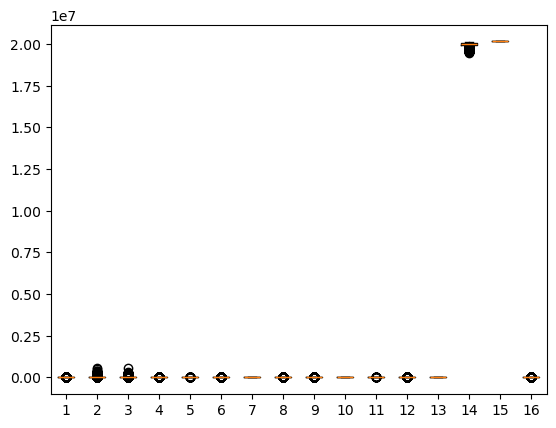

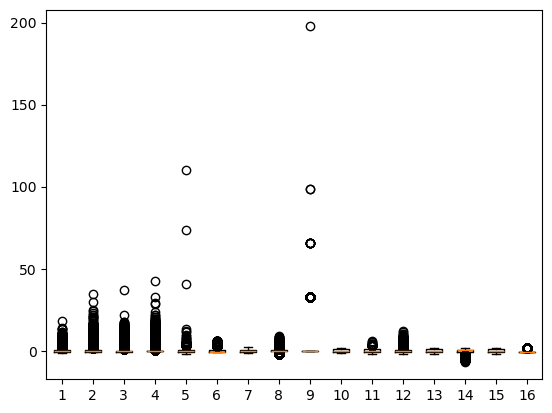

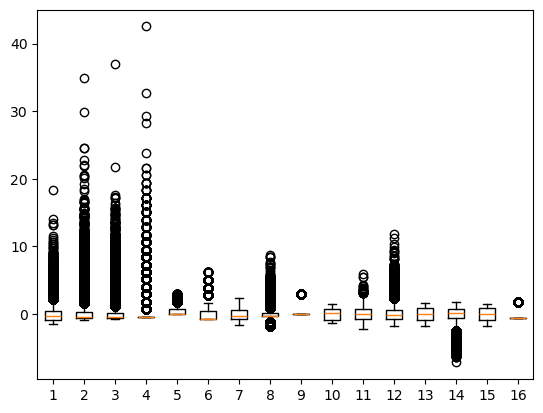

In [3]:
# drop ids
print(data.apply(lambda col: len(col.unique())))
data = data.iloc[:,1:]
data.drop("id", axis=1, inplace=True)

# missing value
na_data = data.loc[data.isna().any(axis=1)]
print(na_data.count().loc[na_data.count() < na_data.shape[0]])

data["emp_title"] = np.where(data["emp_title"].isna(), "unemployed or info unavailable", "employed")
idx = data.loc[(data["mths_since_last_delinq"].isna()) & (data["delinq_2yrs"] > 0)].index
data.drop(idx, inplace=True)
data["mths_since_last_delinq"] = np.where((data["mths_since_last_delinq"].isna()) & (data["delinq_2yrs"] == 0), 24, data["mths_since_last_delinq"])
data["mths_since_last_delinq"] = np.where(data["num_tl_120dpd_2m"] > 0, 0, data["mths_since_last_delinq"])
data["num_tl_120dpd_2m"] = np.where(data["num_tl_120dpd_2m"].isna(), 0, data["num_tl_120dpd_2m"])

na_data = data.loc[data.isna().any(axis=1)]
print(na_data.count().loc[na_data.count() < na_data.shape[0]])

data.dropna(inplace=True)

# separation of continuous and catagorical vars
y = data["target"]
data.drop("target", axis=1, inplace=True)
num = data.loc[:, data.dtypes != object]
cat = data.loc[:, data.dtypes == object]

# add date columns
date_col = ["earliest_cr_line", "issue_d", "term"]
num = num.join(cat[date_col])
num[date_col[-1]] = num[date_col[-1]].str.split(" ").apply(lambda x : x[1]).astype(int)
num[date_col[0]] = pd.to_datetime(num[date_col[0]], format="%b-%Y").dt.strftime('%Y%m%d').astype(int)
num[date_col[1]] = pd.to_datetime(num[date_col[1]], format="%Y-%m-%d").dt.strftime('%Y%m%d').astype(int)

cat.drop(date_col,axis=1,inplace=True)

# decode categorical vars
cat = pd.get_dummies(cat, drop_first=True)

# anomaly
plt.figure(1)
_ = plt.boxplot(num)

num = (num - num.mean()) / num.std()
plt.figure(2)
_ = plt.boxplot(num)
display(num.columns[4], num[num.columns[4]].max())
display(num.columns[8], num[num.columns[8]].max())

to_clip = num.columns[[4,8]]
for i in range(to_clip.shape[0]):
    num[to_clip[i]] = np.clip(num[to_clip[i]], 0, num[to_clip[i]].mean() + 3 * num[to_clip[i]].std())
plt.figure(3)
_ = plt.boxplot(num)
display(num.columns[0:4])

In [4]:
# predictive power 1
df1 = num.join(y)
pc1 = df1.groupby("target").mean().T

df2 = cat.join(y)
pc2 = df2.groupby("target").mean().T

# further check on predictive power
grouped1 = df1.groupby("target").apply(lambda x :x).drop("target", axis=1)
pval_list1 = []
for col in grouped1.columns:
    _,pval,_ = sm.stats.ttest_ind(grouped1.loc[0][col], grouped1.loc[1][col])
    pval_list1.append(pval)
pc1["p_value"] = pval_list1
display(pc1)

grouped2 = df2.groupby("target").apply(lambda x :x).drop("target", axis=1)
pval_list2 = []
for col in grouped2.columns:
    _,pval = sm.stats.test_proportions_2indep(grouped2.loc[0][col].sum(),grouped2.loc[0][col].shape[0],grouped2.loc[1][col].sum(),grouped2.loc[1][col].shape[0])
    pval_list2.append(pval)
pc2["p_value"] = pval_list2
display(pc2)

# multicollinearity 1
corr_table = num.corr()
cor_loc = np.argwhere(abs(corr_table) > 0.7)
display(cor_loc[cor_loc[:,0] != cor_loc[:,1]])

# further check on multicollinearity
VIF = np.linalg.inv(corr_table).diagonal()
display(VIF)

target,0.0,1.0,p_value
acc_open_past_24mths,-0.064353,0.254999,0.000000e+00
avg_cur_bal,0.039307,-0.155754,0.000000e+00
bc_open_to_buy,0.043182,-0.171107,0.000000e+00
delinq_2yrs,-0.007617,0.030181,1.051037e-19
dti,0.366772,0.531431,0.000000e+00
inq_last_6mths,-0.044215,0.175199,0.000000e+00
loan_amnt,-0.032014,0.126854,0.000000e+00
mths_since_last_delinq,-0.002260,0.008954,7.044409e-03
num_tl_120dpd_2m,0.002052,0.002489,1.897687e-01
percent_bc_gt_75,-0.035329,0.139989,0.000000e+00


C:\Users\chenm\anaconda3\Lib\site-packages\statsmodels\stats\proportion.py:1769: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = p1 / p2
C:\Users\chenm\anaconda3\Lib\site-packages\statsmodels\stats\proportion.py:1770: RuntimeWarning: divide by zero encountered in scalar divide
  odds_ratio = p1 / (1 - p1) / p2 * (1 - p2)


target,0.0,1.0,p_value
emp_title_unemployed or info unavailable,0.055087,0.072995,1.942830e-64
grade_B,0.311628,0.185329,0.000000e+00
grade_C,0.269376,0.309693,4.625026e-99
grade_D,0.118946,0.226452,0.000000e+00
grade_E,0.054333,0.156762,0.000000e+00
grade_F,0.013096,0.055130,0.000000e+00
grade_G,0.002837,0.013330,5.207200e-127
purpose_credit_card,0.251555,0.200926,1.042153e-195
purpose_debt_consolidation,0.580414,0.634015,5.794372e-156
purpose_educational,0.000003,0.000000,6.409012e-01


array([[ 9, 10],
       [10,  9]], dtype=int64)

array([1.47651973, 1.11564092, 1.53516095, 1.23717094, 1.09326906,
       1.11942645, 1.40458642, 1.20252294, 1.00322743, 2.14187432,
       2.42658288, 1.53834868, 1.00002865, 1.15633897, 1.00547302,
       1.19237018])

In [5]:
# drop features
to_drop = pc1.loc[pc1["p_value"] > 0.05].index.values
to_drop = np.hstack((to_drop, pc2.loc[pc2["p_value"] > 0.05].index.values))
to_drop = np.append(to_drop, num.columns[10])
print(to_drop)

X = num.join(cat)
X.drop(to_drop, axis=1,inplace=True)
X = X.astype(float)
y = y.astype(float)

# model - first iteration
log_reg = sm.Logit(y, sm.add_constant(X)).fit() 
summary = log_reg.summary()
p_val = log_reg.pvalues

display(summary, p_val)
to_drop2 = p_val.loc[p_val > 0.05].index.values
print(X.columns, to_drop2)

X.drop(to_drop2,axis=1,inplace=True)

['num_tl_120dpd_2m' 'age' 'issue_d' 'purpose_educational'
 'purpose_major_purchase' 'purpose_medical' 'purpose_renewable_energy'
 'purpose_wedding' 'revol_util']
Optimization terminated successfully.
         Current function value: 0.429779
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:               358886
Model:                          Logit   Df Residuals:                   358855
Method:                           MLE   Df Model:                           30
Date:                Mon, 09 Sep 2024   Pseudo R-squ.:                  0.1447
Time:                        23:03:33   Log-Likelihood:            -1.5424e+05
converged:                       True   LL-Null:                   -1.8034e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -3.1541      0.031   -100.446      0.000      -3.216      -3.093
acc_open_past_24mths                         0.2028      0.005     37.471      0.000       0.192       0.213
avg_cur_bal                                 -0.2317      0.006    -37.642      0.000      -0.244      -0.220
bc_open_to_buy                              -0.1003      0.007    -14.220      0.000      -0.114      -0.086
delinq_2yrs                                  0.0657      0.005     13.825      0.000       0.056       0.075
dti                                          0.2100      0.008     27.873      0.000       0.195       0.225
inq_last_6mths                               0.0621      0.005     13.630      0.000       0.053       0.071
loan_amnt                                    0.0567      0.006     10.099      0.000       0.046       0.068
mths_since_last_delinq                      -0.0006      0.005     -0.133      0.894      -0.010       0.009
percent_bc_gt_75                             0.0637      0.005     11.930      0.000       0.053       0.074
total_acc                                   -0.0982      0.006    -16.946      0.000      -0.110      -0.087
earliest_cr_line                             0.0260      0.005      5.105      0.000       0.016       0.036
term                                         0.3415      0.005     67.868      0.000       0.332       0.351
emp_title_unemployed or info unavailable     0.4213      0.019     22.273      0.000       0.384       0.458
grade_B                                      0.6165      0.020     31.027      0.000       0.578       0.655
grade_C                                      1.0374      0.020     50.975      0.000       0.997       1.077
grade_D                                      1.3332      0.022     59.454      0.000       1.289       1.377
grade_E                                      1.5019      0.025     59.467      0.000       1.452       1.551
grade_F                                      1.7242      0.033     51.731      0.000       1.659       1.789
grade_G                                      1.7714      0.056     31.890      0.000       1.663       1.880
purpose_credit_card                         -0.0134      0.026     -0.511      0.609      -0.065       0.038
purpose_debt_consolidation                  -0.0119      0.025     -0.479      0.632      -0.060       0.037
purpose_home_improvement                    -0.0322      0.031     -1.045      0.296      -0.093       0.028
purpose_house                               -0.1255      0.074     -1.703      0.089      -0.270       0.019
purpose_moving                               0.0307      0.059      0.521      0.602      -0.085       0.146
purpose_other                               -0.0519      0.031     -1.653      0.098      -0.113       0.010
purpose_small_business                       0.1706      0.050      3.384      0

const                                        0.000000e+00
acc_open_past_24mths                        2.775234e-307
avg_cur_bal                                 4.415394e-310
bc_open_to_buy                               6.894275e-46
delinq_2yrs                                  1.805790e-43
dti                                         5.723522e-171
inq_last_6mths                               2.671279e-42
loan_amnt                                    5.596878e-24
mths_since_last_delinq                       8.944060e-01
percent_bc_gt_75                             8.287324e-33
total_acc                                    2.053841e-64
earliest_cr_line                             3.307207e-07
term                                         0.000000e+00
emp_title_unemployed or info unavailable    6.824943e-110
grade_B                                     2.339515e-211
grade_C                                      0.000000e+00
grade_D                                      0.000000e+00
grade_E       

Index(['acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'delinq_2yrs',
       'dti', 'inq_last_6mths', 'loan_amnt', 'mths_since_last_delinq',
       'percent_bc_gt_75', 'total_acc', 'earliest_cr_line', 'term',
       'emp_title_unemployed or info unavailable', 'grade_B', 'grade_C',
       'grade_D', 'grade_E', 'grade_F', 'grade_G', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_moving', 'purpose_other',
       'purpose_small_business', 'purpose_vacation',
       'verification_status_Source Verified', 'verification_status_Verified',
       'gender_Male'],
      dtype='object') ['mths_since_last_delinq' 'purpose_credit_card'
 'purpose_debt_consolidation' 'purpose_home_improvement' 'purpose_house'
 'purpose_moving' 'purpose_other' 'purpose_vacation']


In [6]:
# separation of train and test
data_to_fit = X.join(y)

train = data_to_fit.sample(frac=0.75)
test = data_to_fit.sample(frac=0.25)

X_train = train.drop(columns=["target"])
y_train = train["target"]

X_test = test.drop(columns=["target"])
y_test = test["target"]

# train analytics
log_reg = sm.Logit(y_train, sm.add_constant(X_train)).fit()
display(log_reg.summary())

# threshold
X_pred = sm.add_constant(X_train)
train_pred = log_reg.predict(X_pred)
thres = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
result = []
for i in range(9):                                                                         
    train_pred_bi = np.where(train_pred>thres[i], 1, 0)                                                   
    train_accuracy = accuracy_score(y_train,train_pred_bi)
    result.append(train_accuracy)
display(result)
temp = np.array((thres,result)).T
thres = temp[temp[:,1] == temp[:,1].max()].flatten()[0]
print(thres)

# prediction
X_test_pred = sm.add_constant(X_test)
test_pred = log_reg.predict(X_test_pred)
fpr, tpr, _ = roc_curve(y_test, test_pred)
roc_auc = auc(fpr,tpr)
print(roc_auc)

test_pred_bi = np.where(test_pred>thres, 1, 0)                                                   
test_accuracy = accuracy_score(y_test,test_pred_bi)
print(test_accuracy)

Optimization terminated successfully.
         Current function value: 0.430293
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:               269164
Model:                          Logit   Df Residuals:                   269141
Method:                           MLE   Df Model:                           22
Date:                Mon, 09 Sep 2024   Pseudo R-squ.:                  0.1443
Time:                        23:03:34   Log-Likelihood:            -1.1582e+05
converged:                       True   LL-Null:                   -1.3534e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -3.1570      0.023   -136.026      0.000      -3.203      -3.112
acc_open_past_24mths                         0.1995      0.006     32.158      0.000       0.187       0.212
avg_cur_bal                                 -0.2325      0.007    -32.950      0.000      -0.246      -0.219
bc_open_to_buy                              -0.0991      0.008    -12.279      0.000      -0.115      -0.083
delinq_2yrs                                  0.0647      0.005     12.828      0.000       0.055       0.075
dti                                          0.2103      0.009     24.309      0.000       0.193       0.227
inq_last_6mths                               0.0633      0.005     12.039      0.000       0.053       0.074
loan_amnt                                    0.0565      0.006      8.874      0.000       0.044       0.069
percent_bc_gt_75                             0.0628      0.006     10.308      0.000       0.051       0.075
total_acc                                   -0.0919      0.007    -13.828      0.000      -0.105      -0.079
earliest_cr_line                             0.0287      0.006      4.893      0.000       0.017       0.040
term                                         0.3399      0.006     58.790      0.000       0.329       0.351
emp_title_unemployed or info unavailable     0.4396      0.022     20.195      0.000       0.397       0.482
grade_B                                      0.6152      0.023     26.945      0.000       0.570       0.660
grade_C                                      1.0298      0.023     44.442      0.000       0.984       1.075
grade_D                                      1.3420      0.025     52.971      0.000       1.292       1.392
grade_E                                      1.4948      0.028     52.465      0.000       1.439       1.551
grade_F                                      1.7251      0.038     45.684      0.000       1.651       1.799
grade_G                                      1.7485      0.064     27.250      0.000       1.623       1.874
purpose_small_business                       0.2006      0.052      3.878      0.000       0.099       0.302
verification_status_Source Verified          0.0904      0.014      6.451      0.000       0.063       0.118
verification_status_Verified                 0.0653      0.015      4.222      0.000       0.035       0.096
gender_Male                                  0.9471      0.011     86.134      0.000       0.926       0.969
============================================================================================================
"""

[0.4924395535807166,
 0.6855448722711804,
 0.7712398389086208,
 0.8031497525672081,
 0.8092909898797759,
 0.8059621643310398,
 0.8000215482010967,
 0.7984202939471846,
 0.7982419640070737]

0.5
0.7616816874266035
0.8116292548092998
